In [1]:
import xarray as xr
from xgcm import Grid
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rootdir = '/local/data/bSOSE/'
niter = 'iter133NEW'
freq = '5day'
chunks = 1
# Load velocity data
filenames = 'bsose_i133_2013to2018_5day_*vel.nc'
ds_vel = xr.open_mfdataset(rootdir+niter+'/'+freq+'/'+filenames,chunks={'time':chunks})
# Load temperature (only necessary here to get hFacC dimension)
filenames = 'bsose_i133_2013to2018_5day_Theta.nc'
ds_theta = xr.open_mfdataset(rootdir+niter+'/'+freq+'/'+filenames,chunks={'time':chunks})
# Load SSH snapshots
filenames = 'bsose_i133_2013to2018_5daySnaps_SSH.nc'
ds_ssh = xr.open_mfdataset(rootdir+niter+'/'+freq+'/'+filenames,chunks={'time':chunks})
ds_ssh = ds_ssh.rename({'time':'time_snaps','ETAN':'ETAN_snaps'}).drop('iter')
# Specify shift of time axis
ds_ssh['time_snaps'].attrs['c_grid_axis_shift']=-0.5
# Load FW flux
freq = '1day'
filenames = 'bsose_i133_2013to2018_1dy_oceFWflx.nc'
ds_fw = xr.open_mfdataset(rootdir+niter+'/'+freq+'/'+filenames,chunks={'time':chunks})
ds_fw = ds_fw.coarsen(time=5,boundary='trim',keep_attrs=True).mean().assign_coords({'time':ds_vel['time']})

# Merge to full dataset
ds = xr.merge([ds_vel,ds_ssh,ds_fw,ds_theta])

# Define vertical metrics as negative, to account for descending coordinate
ds['drW'] = ds.hFacW * ds.drF #vertical cell size at u point
ds['drS'] = ds.hFacS * ds.drF #vertical cell size at v point
ds['drC'] = ds.hFacC * ds.drF #vertical cell size at tracer point
# Volume
ds['vC'] = ds['drC']*ds['rA']
# Define cell side areas
ds['rAW'] = ds['dyG']*ds['drW']
ds['rAS'] = ds['dxG']*ds['drS']

# Define time metric
# HACK: trouble with time difference metric, so here just setting up own array with 5-days in seconds 
dt = xr.DataArray(432000*np.ones(shape=(438)),dims='time')
# Reference density
rho0 = 1035.0

metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drW', 'drS', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
}

xgrid = Grid(ds,periodic=['X'],metrics=metrics)

In [3]:
# Mask to set surface velocity point to zero
tmp = np.ones(len(ds['Zl']))
tmp[0]=0
maskZl = xr.DataArray(tmp,dims=['Zl'],coords={'Zl':ds['Zl']})

In [4]:
# Volume cellwise budget
budget = xr.Dataset()
budget['TEND'] = rho0*xgrid.diff(ds['ETAN_snaps'],'T')/dt
budget['SURF'] = ds['oceFWflx']
budget['CORR']= rho0*ds['WVEL'].isel(Zl=0)
tmp = -1*rho0*(xgrid.diff(ds['UVEL']*ds['rAW'],'X')+
               xgrid.diff(ds['VVEL']*ds['rAS'],'Y',boundary='extend')+
               (-1*xgrid.diff(ds['WVEL']*maskZl*ds['rA'],'Z',boundary='extend')))/ds['rA']
budget['DIV'] = tmp.isel(Z=0)

In [5]:
signs = {'TEND':-1,'DIV':1,'CORR':1,'SURF':1}

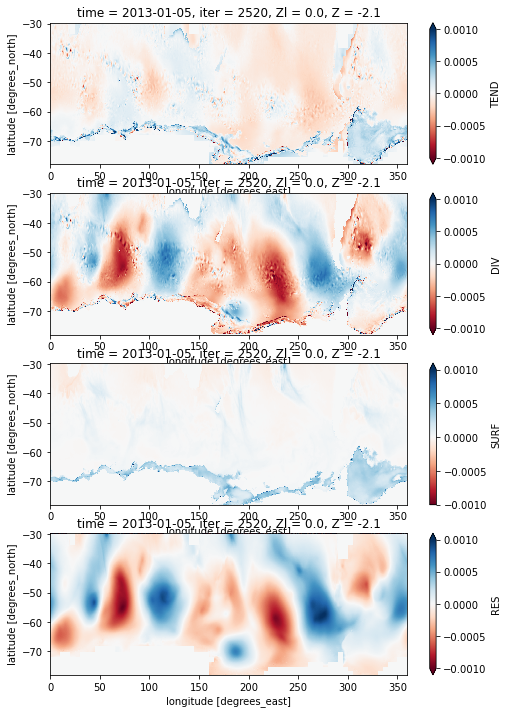

In [59]:
select = {'time':0}
terms=['TEND','DIV','SURF']
fig,axarr = plt.subplots(figsize=(8,4*len(terms)),nrows=len(terms)+1)
RES = xr.zeros_like(budget[terms[0]].isel(select))
RES.name='RES'
for i,term in enumerate(terms):
    ax = axarr.flat[i]
    budget[term].isel(select).plot(ax=ax,vmin=-0.001,vmax=0.001,cmap='RdBu')
    RES += signs[term]*budget[term].isel(select)
ax=axarr.flat[-1]    
RES.plot(ax=ax,vmin=-0.001,vmax=0.001,cmap='RdBu')

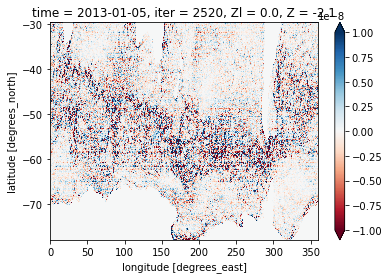

In [55]:
(budget['DIV']+budget['CORR']).isel(time=0).plot(vmin=-0.00000001,vmax=0.00000001,cmap='RdBu')

In [ ]:
budget['CORR'].isel(time=0).plot(vmin=-0.001,vmax=0.001,cmap='RdBu')